# Helmholtz 1D - AutoAMG on a Fixed Domain Size - Multilevel

## Goal
Given the Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with periodic boundary conditions, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, and a multilevel hierarchy that is able to solve $A u = f$ fast.

In general, $k=k(x)$ varies over the domain. In thesse experiments, $k$ is constant, but we do not assume this knowledge.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. In this experiment we use a fixed periodic domain with $n=96$ points and a small $kh=0.5$.

In [23]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm
from scipy.sparse.linalg import eigs

import helmholtz as hm
import helmholtz.setup.hierarchy as hierarchy

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Finest-level Eigenvalues

Smallest-magnitude eigenvalue -0.02393225657483029


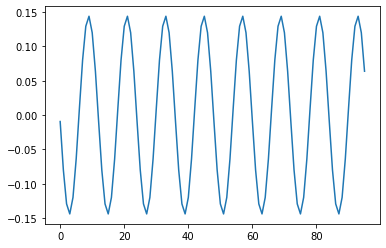

In [50]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

lam, v = eig(a.todense())
lam = np.real(lam)
ind = np.argsort(np.abs(lam))
lam = lam[ind]
v = v[:, ind]
print("Smallest-magnitude eigenvalue", lam[0])
plt.plot(v[:, 0]);

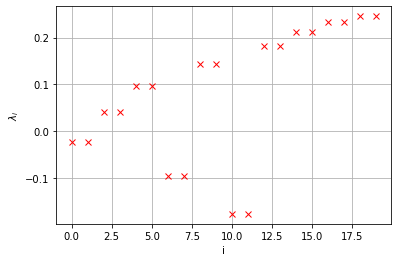

In [25]:
plt.plot(lam[:20], "rx")
plt.grid(True)
plt.xlabel("i")
plt.ylabel(r"$\lambda_i$");

## Two-level Bootstrap
We perform 4 bootstrap cycles, starting from 20 random test functions.
* R is constructed by SVD.
<!-- * P is contructed by regularized LS. -->
* P = R^T.
We measure the Residual to Error Ratio (RER) of test functions the two-level cycle convergence factor for $A x = 0$ (solving exactly at the coarse level), with $\nu_1+\nu_2=4$ relaxations per cycle 

In [26]:
# Fixed seed for reproducible results.
np.random.seed(0)

num_examples = 20
max_levels = 2
num_bootstrap_steps = 3
threshold = 0.1
interpolation_method = "svd" # "ls"
num_sweeps = 10

In [27]:
# # Initialize test functions (to random) and hierarchy at coarsest level.
# level = hierarchy.create_finest_level(a)
# multilevel = hm.hierarchy.multilevel.Multilevel(level)

# x, multilevel = hm.setup.auto_setup.setup(a, max_levels=3, num_bootstrap_steps=num_bootstrap_steps, num_examples=20,
#                               interpolation_method="svd", threshold=0.1)

## Level 0->1: Two-level Coarsening + Bootstrapping

In [28]:
_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
level = hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel(level)
# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
x, conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x,num_sweeps=num_sweeps)
_LOGGER.info("Relax convergence factor {:.3f}".format(conv_factor))
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("-" * 80)
_LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
x_log[num_levels] = [x]
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, num_levels, num_sweeps=num_sweeps,
                             interpolation_method=interpolation_method, threshold=threshold)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x2 = x

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.875
INFO     RER 0.318
INFO     --------------------------------------------------------------------------------
INFO     bootstrap with 96 levels
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.994
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 8 4 4 8 4 8 8]
INFO     Mock cycle conv factor [0.607 0.379 0.247 0.206 0.157]
INFO     Level 1 size 47
INFO     RER 0.163
INFO     Bootstrap step 2/3
INFO     Relax cycle conv factor 0.834
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Mock cycle conv factor [0.592 0.333 0.19  0.137 0.141]
INFO     Level 1 size 48
INFO     RER 0.086
INFO     Bootstrap step 3/3
INFO     Relax cycle conv factor 0.921
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Mock cycle conv factor [0.586 0.332 0.199 0.135

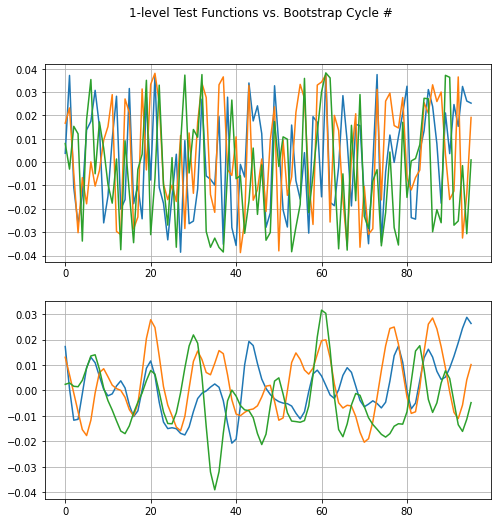

In [29]:
x_all = x_log[1]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('1-level Test Functions vs. Bootstrap Cycle #')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

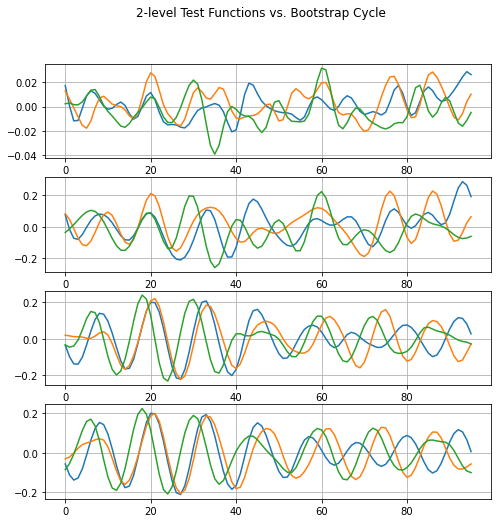

In [30]:
x_all = x_log[2]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

In [31]:
# # Bootstrap 3 levels.
# x = x2
# num_levels = 3
# _LOGGER.info("-" * 80)
# _LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
# x_log[num_levels] = [x]
# for i in range(num_bootstrap_steps):
#     _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
#     x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, num_levels, num_sweeps=num_sweeps,
#                              interpolation_method=interpolation_method, threshold=threshold)
#     x_log[num_levels].append(x)
#     _LOGGER.info("RER {:.2f}".format(norm(a.dot(x)) / norm(x)))

In [32]:
# x_all = x_log[3]
# fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
# fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
# for i, x in enumerate(x_all):
#     ax = axs[i]
#     for j in range(5):
#         ax.plot(x[:, j])
#     ax.grid(True);

## Level 1->2: Two-level Coarsening + Bootstrapping

In [162]:
level = multilevel.level[1]
a1 = level.a
x = level.coarsen(x2)
np.random.seed(0)

# x1_improved, multilevel1 = hm.setup.auto_setup.setup(a1, max_levels=2, 
#                                                      num_bootstrap_steps=5,
#                                                      num_sweeps=30, print_frequency=3,
#                                                      num_examples=num_examples, 
#                                                      interpolation_method=interpolation_method, 
#                                                      threshold=threshold, x=x1)

_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions from finer level.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel(level)
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
print(x.shape, b.shape, level.size)
x, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))
_LOGGER.info("RER {:.3f}".format(norm(a1.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("-" * 80)
_LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
x_log[num_levels] = [x]
for i in range(20):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, relax_conv_factor,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold,
        print_frequency=1)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a1.dot(x)) / norm(x)))

INFO     Relax at level 0 size 48
(48, 20) (48, 20) 48
INFO     Relax convergence factor 0.996
INFO     RER 0.062
INFO     --------------------------------------------------------------------------------
INFO     bootstrap with 48 levels
INFO     Bootstrap step 1/3


TypeError: bootstap() missing 1 required positional argument: 'relax_conv_factor'

* Even though the test function RER decreases, the two-level convergence factor is excellent after one bootstrap cycle, then gets worse.
* Even though $R$ is accurate in the energy norm (i.e., the coarse values reconstruct the value of the fine variables to $10\%$ error), theer exist test functions (not used in the fit) with large interpolation error ($100\%$!).

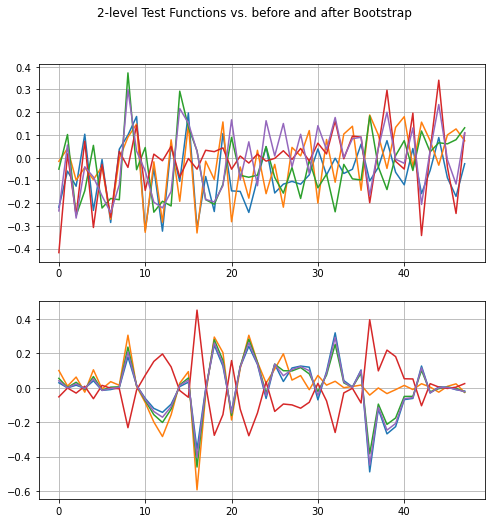

In [115]:
x_all = [x1, x1_improved]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. before and after Bootstrap')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(5):
        ax.plot(x[:, j])
    ax.grid(True);

In [35]:
# Append level 2 found by 1->2 coarsening into the hierarchy of level 0.
#multilevel.level.append(multilevel1.level[1])
multilevel.level.append(multilevel1.level[1])

## Relaxation Cycle Convergence Factor vs. #levels

In [127]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
level = multilevel.level[0]
b = np.zeros((level.size, ))

y_all = {}
for num_levels in range(1, len(multilevel.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        10, print_frequency=1)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

#levels 1
INFO         0 |r| 2.92248235e+00 RER 2.92248
INFO         1 |r| 4.36998972e-01 (0.14953) RER 0.82131 (0.28103) 0.53208
INFO         2 |r| 1.73069295e-01 (0.39604) RER 0.36834 (0.44848) 0.46986
INFO         3 |r| 1.20742675e-01 (0.69766) RER 0.27266 (0.74024) 0.44283
INFO         4 |r| 9.99072381e-02 (0.82744) RER 0.23577 (0.86471) 0.42374
INFO         5 |r| 8.84359618e-02 (0.88518) RER 0.21668 (0.91903) 0.40814
INFO         6 |r| 8.10851476e-02 (0.91688) RER 0.20551 (0.94846) 0.39455
INFO         7 |r| 7.56492867e-02 (0.93296) RER 0.19786 (0.96278) 0.38233
INFO         8 |r| 7.13157465e-02 (0.94272) RER 0.19215 (0.97114) 0.37114
INFO         9 |r| 6.77034411e-02 (0.94935) RER 0.18767 (0.97665) 0.36077
INFO        10 |r| 6.45768381e-02 (0.95382) RER 0.18394 (0.98015) 0.35107
Conv Factor 0.93905
#levels 2
INFO         0 |r| 3.02875236e+00 RER 3.02875
INFO         1 |r| 8.75058041e-01 (0.28892) RER 0.87506 (0.28892) 1.00000
INFO         2 |r| 4.22789905e-01 (0.48316) RER 0.4227

0.07110417488003867


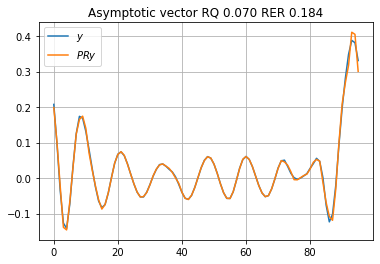

In [85]:
# Asymptotic vector of 3-level relaxation cycle is a smooth component.
coarse_level = multilevel.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[3].flatten()
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
plt.plot(y, label="$y$")
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

### Level 1->2 Relaxation Cycle

In [87]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
l = 1
level = multilevel.level[l]
b = np.zeros((level.size, ))
ml = hm.hierarchy.multilevel.Multilevel(level)
ml.level = multilevel.level[l:]

y_all = {}
for num_levels in range(1, len(ml.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(ml, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        10,  print_frequency=1)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

#levels 1
INFO         0 |r| 1.09266990e+00 RER 1.09267
INFO         1 |r| 1.93054137e-01 (0.17668) RER 0.29070 (0.26604) 0.66411
INFO         2 |r| 1.28439829e-01 (0.66530) RER 0.21971 (0.75579) 0.58460
INFO         3 |r| 9.43495333e-02 (0.73458) RER 0.17625 (0.80219) 0.53532
INFO         4 |r| 7.46075907e-02 (0.79076) RER 0.14885 (0.84454) 0.50123
INFO         5 |r| 6.19926163e-02 (0.83092) RER 0.13025 (0.87505) 0.47595
INFO         6 |r| 5.31253857e-02 (0.85696) RER 0.11638 (0.89354) 0.45647
INFO         7 |r| 4.64587423e-02 (0.87451) RER 0.10533 (0.90500) 0.44109
INFO         8 |r| 4.12336720e-02 (0.88753) RER 0.09618 (0.91311) 0.42873
INFO         9 |r| 3.70282952e-02 (0.89801) RER 0.08845 (0.91965) 0.41865
INFO        10 |r| 3.35784514e-02 (0.90683) RER 0.08184 (0.92530) 0.41029
Conv Factor 0.88459
#levels 2
INFO         0 |r| 1.01977492e+00 RER 1.01977
INFO         1 |r| 3.77280285e-01 (0.36996) RER 0.37728 (0.36996) 1.00000
INFO         2 |r| 3.56244322e-01 (0.94424) RER 0.3562

0.5964260010714636


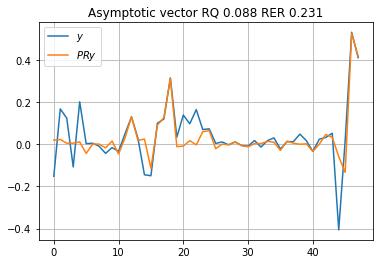

In [122]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is still smooth.
coarse_level = ml.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[2].flatten()
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

### Fine vs. Coarse Operator Eigenvalues

In [74]:
lam = [None] * len(multilevel)
v = [None] * len(multilevel)
for l in range(len(multilevel)):
    level = multilevel.level[l]
    lam[l], v[l] = eig(level.a.todense(), b=level.b.todense())
    lam[l] = np.real(lam[l])
    ind = np.argsort(np.abs(lam[l]))
    lam[l] = lam[l][ind]
    v[l] = v[l][:, ind]

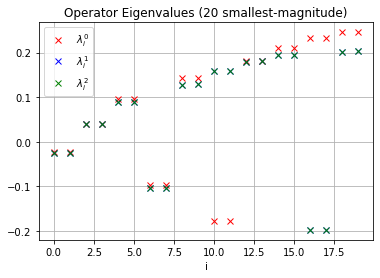

In [75]:
k = 20
lf = lam[0][:k][:, None] 
lc = lam[1][:k][:, None]
l2 = lam[2][:k][:, None]

plt.plot(lf, 'rx', label="$\lambda_i^0$")
plt.plot(lc, 'bx', label="$\lambda_i^1$")
plt.plot(lc, 'gx', label="$\lambda_i^2$")
plt.xlabel("i")
plt.grid(True)
plt.title("Operator Eigenvalues ({} smallest-magnitude)".format(k));
plt.legend();
#plt.xlim([-0.3, 0.3]);
#plt.ylim([-0.1, 0.1]);

In [76]:
pd.DataFrame(np.concatenate((lf, lc, l2,
                             np.abs(lc - lf)/np.abs(lf), np.abs(l2 - lf)/np.abs(lf),
                            ),  axis=1),
            columns=("lam0", "lam1", "lam2", "rel error 1", "rel error 2"))

,lam0,lam1,lam2,rel error 1,rel error 2
0,-0.023932,-0.024471,0.000322,0.022508,1.013435
1,-0.023932,-0.024510,0.011777,0.024148,1.492096
2,0.040200,0.038818,-0.028501,0.034380,1.708965
3,0.040200,0.039147,0.033101,0.026204,0.176595
4,0.095828,0.089195,0.044266,0.069215,0.538065
5,0.095828,0.089365,0.071623,0.067437,0.252589
6,-0.096528,-0.102860,0.093031,0.065593,1.963770
7,-0.096528,-0.103282,-0.189146,0.069966,0.959487
8,0.142921,0.128248,-0.211787,0.102669,2.481845
9,0.142921,0.128496,-0.219085,0.100934,2.532906


Eigenvalue -0.023932256574829756 -0.024470927030489788 -0.02850069724117531


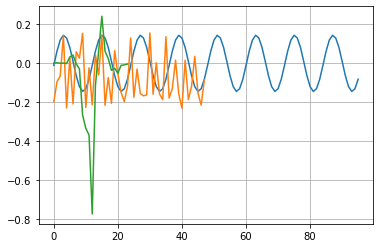

In [78]:
# Lowesst eigenfunction at levels 0..2.
plt.plot(v[0][:, 0])
plt.plot(v[1][:, 0])
plt.plot(v[2][:, 2])
plt.grid(True);
print("Eigenvalue", lam[0][0], lam[1][0], lam[2][2])

## Observations
#### 2-level
* We get a good result: mock cycle rates are good and improve with #relaxation sweeps (0.53, 0.33, 0.2, ...).
* The test function RER decreases with bootstrap cycles.
* The two-level relaxation cycle is able to reduce the residual faster than 1-level relaxation.

#### 3-level
* The mock cycle rates are much larger, but still improve with the number of relaxation sweeps, indicating that Kaczmarz is a less effective smoother for the level 1 equations than level 0 (~0.85, 0.81, 0.79, ...) and that we need more relaxations at level 1 during a cycle.
* The test function RER oscillates with bootstrap cycles.
* The 3-level relaxation cycle RER does not converge to the smallest eigenvalue. This indicates that there is a error component that is not reduced at all.

#### Questions
* We have a good quality metric of test functions (RER). We have a good metric of a coarsening operator (mock cycle). What is a good qualiy metric of a coarse level? Is it the convergence rate of a 2-level relaxation cycle? (converrgence needs to be measured towards the lowest eigenpair?).
* How can we find which points are not coarsened well? Can we tell by the asymptotically slowest vector of the relaxation cycle?

In [146]:
from scipy.linalg import svd

In [149]:
X = np.random.random((10, 5))
W = np.diag(np.random.random(10,))

In [151]:
svd(X)

(array([[-0.405,  0.19 , -0.261, -0.025,  0.404, -0.223,  0.122, -0.014, -0.608, -0.366],
        [-0.21 ,  0.376, -0.606,  0.089, -0.09 ,  0.299, -0.178,  0.388,  0.063,  0.394],
        [-0.371, -0.191, -0.222,  0.272, -0.189, -0.683,  0.214, -0.002,  0.382,  0.094],
        [-0.345,  0.049, -0.095, -0.343,  0.189,  0.048, -0.564, -0.435,  0.416, -0.185],
        [-0.281, -0.217,  0.087, -0.79 , -0.027,  0.008,  0.328,  0.22 , -0.022,  0.293],
        [-0.336, -0.613, -0.164,  0.28 ,  0.019,  0.573,  0.212, -0.112,  0.021, -0.138],
        [-0.172,  0.494,  0.032, -0.075, -0.56 ,  0.204,  0.416, -0.319,  0.076, -0.289],
        [-0.317, -0.052,  0.357,  0.046, -0.333,  0.   , -0.355,  0.602, -0.02 , -0.409],
        [-0.162,  0.321,  0.35 ,  0.17 ,  0.572,  0.147,  0.332,  0.232,  0.454, -0.025],
        [-0.433,  0.103,  0.47 ,  0.247, -0.067,  0.024, -0.168, -0.284, -0.308,  0.559]]),
 array([3.76 , 1.054, 0.737, 0.617, 0.354]),
 array([[-0.41 , -0.426, -0.372, -0.511, -0.501],
   

In [152]:
svd(W.dot(X))

(array([[-0.099,  0.065, -0.108,  0.008,  0.128, -0.528, -0.069, -0.187, -0.584, -0.547],
        [-0.188,  0.254, -0.776, -0.218,  0.014,  0.245, -0.121,  0.269, -0.262,  0.184],
        [-0.348, -0.066, -0.209, -0.181, -0.16 , -0.706,  0.066,  0.076,  0.473,  0.2  ],
        [-0.314,  0.145, -0.229,  0.417,  0.283,  0.181, -0.339, -0.391,  0.442, -0.278],
        [-0.21 , -0.028, -0.008,  0.781,  0.108, -0.131,  0.274,  0.257, -0.246,  0.339],
        [-0.587, -0.663,  0.053, -0.22 ,  0.183,  0.265,  0.198, -0.012, -0.112, -0.1  ],
        [-0.089,  0.259, -0.159,  0.045, -0.414,  0.171,  0.738, -0.238,  0.092, -0.294],
        [-0.263,  0.098,  0.214,  0.114, -0.415,  0.096, -0.266,  0.635,  0.086, -0.446],
        [-0.214,  0.529,  0.311, -0.253,  0.609, -0.005,  0.269,  0.247,  0.092, -0.032],
        [-0.473,  0.33 ,  0.346, -0.091, -0.344,  0.059, -0.241, -0.383, -0.274,  0.372]]),
 array([2.024, 0.681, 0.382, 0.287, 0.167]),
 array([[-0.351, -0.525, -0.317, -0.473, -0.526],
   